In [348]:
import configparser
import numpy as np
import time
import xgboost as xgb
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from pycm import ConfusionMatrix

from data_loader import DataLoader
from feature_selector import BaselineSelector, AnalysisSelector
from utils import balanced_split, parse_config_features, shape_wrapper, plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [349]:
seed = 150

def get_model(config: configparser.ConfigParser):
    """
    Returns model by name
    """
    hyperparams = config['Model']
    name = hyperparams['model_name']
    print(name)
    random_state = None if hyperparams['random_state'] == 'None' else int(hyperparams['random_state'])

    if name == 'logistic_regression':
        return LogisticRegression(random_state=random_state)
    
    elif name == 'knn':
        n_neighbors = int(hyperparams['n_neighbors'])
        return KNeighborsClassifier(n_neighbors=n_neighbors)
    
    elif name == 'svm':
        return SVC(random_state=random_state)
    
    elif name == 'random_forest':
        n_estimators = int(hyperparams['n_estimators'])
        max_depth = int(hyperparams['max_depth'])
        return RandomForestClassifier(max_depth=4)
    
    elif name == 'xgboost':
        return xgb.XGBClassifier(learning_rate = 0.1, n_estimators=100, objective='multi:softmax', num_class=3, max_depth=7, min_child_weight=3, random_state=random_state)
    
    elif name == 'naive_bayes':
        return GaussianNB()
    
    else:
        raise ValueError(f'Unknown model name: {name}')

In [350]:
def get_metrics(y_true, y_pred):
    """
    Returns metrics for classification
    """
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred, average='macro'),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'confusion_matrix': ConfusionMatrix(y_true, y_pred)
    }

In [351]:
def train_model(config: configparser.ConfigParser):
    """
    Trains model and returns metrics
    """
    X = pd.read_csv(config['Data']['features_path'])

    y = np.loadtxt(config['Data']['labels_path'], dtype=np.int32)

In [352]:
config_path = './config.ini'
config = configparser.ConfigParser()
config.read(config_path)
config['Model']['model_name']

'random_forest'

In [353]:
X = pd.read_csv(config['Data']['features_path'])

y = np.load(config['Data']['labels_path'])
par_ids = np.load(config['Data']['par_ids_path'])
X['par_ids'] = par_ids
X.drop('Unnamed: 0', axis=1, inplace=True)

In [354]:
n_folds = int(config['Train']['n_folds'])
num_test_part = int(config['Train']['num_test_part'])
model_name = config['Model']['model_name']
print(num_test_part)

5


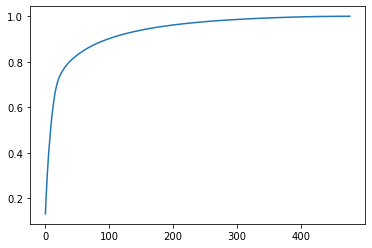

In [355]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)
cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative)

In [356]:
X.drop('Unnamed: 0', axis = 1, inplace = True)

In [357]:
'''dataset_path = config['Data']['dataset_path']
model_name = config['Model']['model_name']

for k in range(n_folds):
    config.set('Model', 'model_name', model_name)

    if n_folds > 1: seed = None
    train_ids, test_ids = balanced_split(dataset_path, num_test_part = num_test_part, seed = seed)

    X_train = X[X['par_ids'].isin(train_ids)]
    X_test = X[X['par_ids'].isin(test_ids)]

    y_train = y[np.isin(par_ids, train_ids)]
    y_test = y[np.isin(par_ids, test_ids)]

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

    X_train = X_train.drop(['par_ids'], axis=1)
    X_test = X_test.drop(['par_ids'], axis=1)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #pca = PCA(n_components=100)
    #X_train = pca.fit_transform(X_train)
    #X_test = pca.transform(X_test)
    
    # oversample
    #oversample = SMOTE()
    #X_train, y_train = oversample.fit_resample(X_train, y_train)

    model = get_model(config)

    print('starting training')
    # train and evaluate model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('finished training')
    metrics = get_metrics(y_test, y_pred)
    print(metrics)'''

"dataset_path = config['Data']['dataset_path']\nmodel_name = config['Model']['model_name']\n\nfor k in range(n_folds):\n    config.set('Model', 'model_name', model_name)\n\n    if n_folds > 1: seed = None\n    train_ids, test_ids = balanced_split(dataset_path, num_test_part = num_test_part, seed = seed)\n\n    X_train = X[X['par_ids'].isin(train_ids)]\n    X_test = X[X['par_ids'].isin(test_ids)]\n\n    y_train = y[np.isin(par_ids, train_ids)]\n    y_test = y[np.isin(par_ids, test_ids)]\n\n    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)\n\n    X_train = X_train.drop(['par_ids'], axis=1)\n    X_test = X_test.drop(['par_ids'], axis=1)\n\n    scaler = StandardScaler()\n    X_train = scaler.fit_transform(X_train)\n    X_test = scaler.transform(X_test)\n\n    #pca = PCA(n_components=100)\n    #X_train = pca.fit_transform(X_train)\n    #X_test = pca.transform(X_test)\n    \n    # oversample\n    #oversample = SMOTE()\n    #X_train, y_train = ov

### Variranje PCA komponenti da vidimo optimalan broj

In [358]:
pca_metrics = []

pca_components =  [50, 100, 200, None]

dataset_path = config['Data']['dataset_path']
model_name = config['Model']['model_name']

print('Model Name')
model = get_model(config)

for n_components in pca_components:
    print('-'*20)
    print(f'PCA components: {n_components}')
    curr_metrics = {}
    
    for k in range(n_folds):

        if n_folds > 1: seed = None
        train_ids, test_ids = balanced_split(dataset_path, num_test_part = num_test_part, seed = seed)

    X_train = X[X['par_ids'].isin(train_ids)]
    X_test = X[X['par_ids'].isin(test_ids)]

    y_train = y[np.isin(par_ids, train_ids)]
    y_test = y[np.isin(par_ids, test_ids)]

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

    X_train = X_train.drop(['par_ids'], axis=1)
    X_test = X_test.drop(['par_ids'], axis=1)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

        if n_components is not None:
            pca = PCA(n_components=n_components)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics = get_metrics(y_test, y_pred)

        print(f'Fold: {k+1}', metrics)

        if k == 0:
            curr_metrics = {k : [v] for k, v in metrics.items() if k != 'confusion_matrix'}
        else:
            curr_metrics ={k : curr_metrics[k] + [v] for k, v in metrics.items() if k != 'confusion_matrix'}

    
    mean_metrics = {k: [np.mean(v), np.std(v)] for k, v in curr_metrics.items()}
    pca_metrics.append(mean_metrics)
    print(f'Mean and std for {n_components} pca components', pca_metrics[-1])

Model Name
random_forest
--------------------
PCA components: 50
Fold: 1 {'accuracy': 0.5319291956083352, 'f1': 0.484348030338549, 'precision': 0.5954304067668122, 'recall': 0.5126319885478826, 'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1, 2])}
Fold: 2 {'accuracy': 0.4734863474475663, 'f1': 0.38854428171762034, 'precision': 0.33784969871288273, 'recall': 0.482058852252738, 'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1, 2])}
Fold: 3 {'accuracy': 0.4526140387419288, 'f1': 0.38078255417761264, 'precision': 0.4498301940588663, 'recall': 0.44258677894713877, 'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1, 2])}
Fold: 4 {'accuracy': 0.5272842639593909, 'f1': 0.4775752974982464, 'precision': 0.6348260638791445, 'recall': 0.516203415416113, 'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1, 2])}
Fold: 5 {'accuracy': 0.45089845382365235, 'f1': 0.3558890123639716, 'precision': 0.34734163998329387, 'recall': 0.4361160212733283, 'confusion_matrix': pycm.Confusion

In [359]:
'''plot_confusion_matrix(metrics['confusion_matrix'])
y_pred_train = model.predict(X_train)
metrics_train = get_metrics(y_test, y_pred)
print(metrics_train)'''

"plot_confusion_matrix(metrics['confusion_matrix'])\ny_pred_train = model.predict(X_train)\nmetrics_train = get_metrics(y_test, y_pred)\nprint(metrics_train)"

In [360]:
'''plt.scatter(pca_components, [m['accuracy'] for m in pca_metrics], label='acc')'''

"plt.scatter(pca_components, [m['accuracy'] for m in pca_metrics], label='acc')"

In [361]:
metrics_df = pd.DataFrame(pca_metrics)
metrics_df['pca_components'] = pca_components
# sort by components
metrics_df = metrics_df.sort_values(by=['pca_components']).reset_index(drop=True)

In [362]:
metrics_df.to_csv('pca_metrics.csv', index=False)